In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

In [43]:
# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Для красивых графиков в ноутбуке
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Загрузка датасета
# Файл data.xlsx, лист "Online Retail"
df = pd.read_excel("data.xlsx", sheet_name="Online Retail")

# Первые 10 строк
print("Первые 10 строк датасета:")
display(df.head(10))

# Основная информация
print("\nИнформация о датасете:")
df.info()

# Размер датасета
print(f"\nРазмер датасета: {df.shape[0]:,} строк × {df.shape[1]} столбцов")

# Проверка на полные дубликаты
dupl = df.duplicated().sum()
print(f"\nПолных дубликатов: {dupl:,} ({dupl/len(df)*100:.2f}%)")

Первые 10 строк датасета:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.6500,17850.0000,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.2500,17850.0000,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.8500,17850.0000,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.8500,17850.0000,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.6900,13047.0000,United Kingdom



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Размер датасета: 541,909 строк × 8 столбцов

Полных дубликатов: 5,268 (0.97%)


In [44]:
# Правильный вид названий столбцов
df.columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 
              'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

print("Тип InvoiceDate после загрузки:", df['InvoiceDate'].dtype)
display(df.head())

print(f"\nИсходный размер датасета: {df.shape[0]:,} строк × {df.shape[1]} столбцов")


if not pd.api.types.is_datetime64_any_dtype(df['InvoiceDate']):
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], unit='D', origin='1899-12-30')
else:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # просто приведение

print(f"Диапазон дат: {df['InvoiceDate'].min()} → {df['InvoiceDate'].max()}")

# ====================== ОЧИСТКА ======================

initial_rows = len(df)

# 1. Удаляем отменённые заказы (InvoiceNo начинается с 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# 2. Только положительные Quantity и UnitPrice
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# 3. Удаляем строки без CustomerID (нам нужны именно клиенты)
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)

# 4. Удаляем полные дубликаты
df = df.drop_duplicates()

final_rows = len(df)
print(f"\nПосле очистки осталось: {final_rows:,} строк")
print(f"Удалено: {initial_rows - final_rows:,} строк ({(1 - final_rows/initial_rows)*100:.2f}%)")

# Краткая статистика
print("\nСтатистика Quantity и UnitPrice после очистки:")
display(df[['Quantity', 'UnitPrice']].describe())

print("\nТоп-10 стран:")
display(df['Country'].value_counts().head(10))

# Проверка, что всё чисто
assert df['CustomerID'].notna().all()
assert (df['Quantity'] > 0).all()
assert (df['UnitPrice'] > 0).all()

Тип InvoiceDate после загрузки: datetime64[ns]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom



Исходный размер датасета: 541,909 строк × 8 столбцов
Диапазон дат: 2010-12-01 08:26:00 → 2011-12-09 12:50:00

После очистки осталось: 392,692 строк
Удалено: 149,217 строк (27.54%)

Статистика Quantity и UnitPrice после очистки:


,Quantity,UnitPrice
count,392692.0000,392692.0000
mean,13.1197,3.1259
std,180.4928,22.2418
min,1.0000,0.0010
25%,2.0000,1.2500
50%,6.0000,1.9500
75%,12.0000,3.7500
max,80995.0000,8142.7500



Топ-10 стран:


Country
United Kingdom    349203
Germany             9025
France              8326
EIRE                7226
Spain               2479
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1453
Australia           1181
Name: count, dtype: int64

In [45]:
# Ячейка 3 - RFM-анализ и агрегация по клиентам

# 1. Рассчитываем RFM для каждого CustomerID
# Recency: дней с последней покупки (относительно max даты)
# Frequency: кол-во уникальных InvoiceNo
# Monetary: суммарная выручка (Quantity * UnitPrice)

current_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'Quantity': lambda x: (x * df.loc[x.index, 'UnitPrice']).sum()  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM-таблица (первые 5 строк):")
display(rfm.head())

# Размер и Базовая статистика RFM
print(f"\nКоличество уникальных клиентов: {len(rfm):,}")

# 2. Дополнительные фичи (опционально, но полезно для кластеризации)
# AvgOrderValue: средний чек (Monetary / Frequency)
# TotalItems: общее кол-во купленных товаров
# UniqueProducts: кол-во уникальных StockCode

additional = df.groupby('CustomerID').agg({
    'Quantity': 'sum',               # TotalItems
    'StockCode': 'nunique'           # UniqueProducts
}).reset_index()

rfm = rfm.merge(additional, on='CustomerID')
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

print("\nРасширенная RFM-таблица (первые 5 строк):")
display(rfm.head())

# 3. Сохранение RFM в отдельный файл
rfm.to_csv('rfm_data.csv', index=False)
print("\nRFM сохранён в 'rfm_data.csv'")

# Проверка
assert len(rfm) == df['CustomerID'].nunique()
print("\nRFM готов - {len(rfm)} клиентов")

RFM-таблица (первые 5 строк):


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.6000
1,12347,2,7,4310.0000
2,12348,75,4,1797.2400
3,12349,19,1,1757.5500
4,12350,310,1,334.4000



Количество уникальных клиентов: 4,338

Расширенная RFM-таблица (первые 5 строк):


,CustomerID,Recency,Frequency,Monetary,Quantity,StockCode,AvgOrderValue
0,12346,326,1,77183.6000,74215,1,77183.6000
1,12347,2,7,4310.0000,2458,103,615.7143
2,12348,75,4,1797.2400,2341,22,449.3100
3,12349,19,1,1757.5500,631,73,1757.5500
4,12350,310,1,334.4000,197,17,334.4000



RFM сохранён в 'rfm_data.csv'

RFM готов - {len(rfm)} клиентов


=== Распределения RFM (с логарифмической шкалой для лучшей читаемости) ===



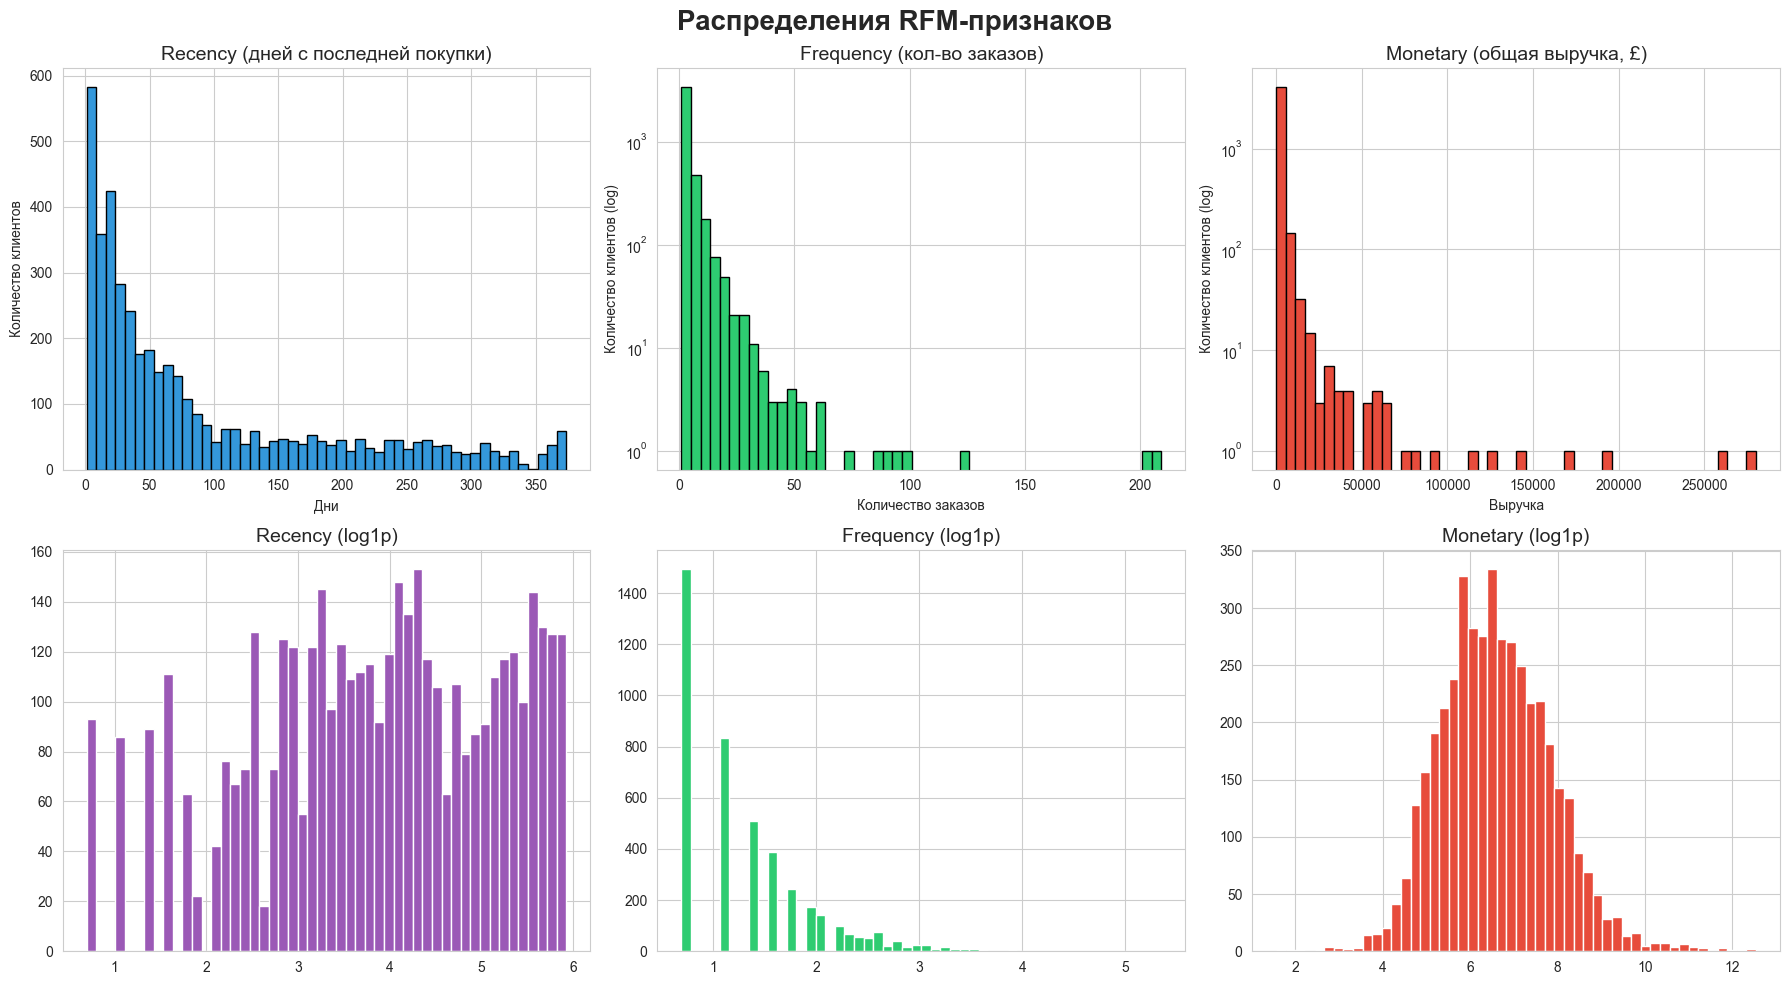

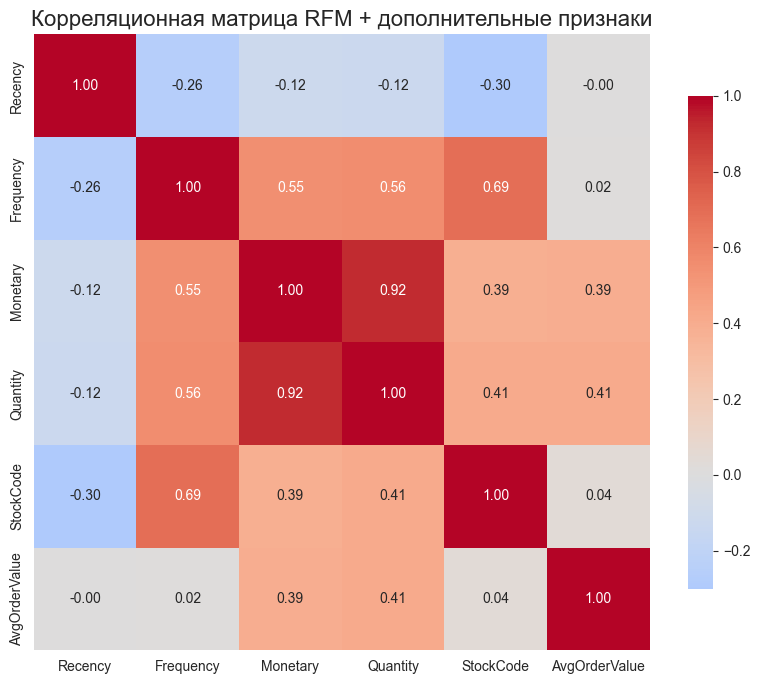


Топ-10 клиентов по выручке (Monetary):


,CustomerID,Monetary,Frequency,Recency
1689,14646,280206.0200,73,2
4201,18102,259657.3000,60,1
3728,17450,194390.7900,46,8
3008,16446,168472.5000,2,1
1879,14911,143711.1700,201,1
55,12415,124914.5300,21,24
1333,14156,117210.0800,55,10
3771,17511,91062.3800,31,3
2702,16029,80850.8400,63,39
0,12346,77183.6000,1,326



Ключевые наблюдения:
Клиентов всего: 4,338
Средний чек (AvgOrderValue): £417.65
Медианная выручка на клиента: £668.57
90-й перцентиль по выручке: £3640.84
Клиентов с одним заказом: 1,493 (34.4%)


In [46]:
# Стиль
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("=== Распределения RFM (с логарифмической шкалой для лучшей читаемости) ===\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Распределения RFM-признаков', fontsize=20, fontweight='bold')

# Recency
axes[0,0].hist(rfm['Recency'], bins=50, color='#3498db', edgecolor='black')
axes[0,0].set_title('Recency (дней с последней покупки)', fontsize=14)
axes[0,0].set_xlabel('Дни')
axes[0,0].set_ylabel('Количество клиентов')

# Frequency
axes[0,1].hist(rfm['Frequency'], bins=50, color='#2ecc71', edgecolor='black')
axes[0,1].set_title('Frequency (кол-во заказов)', fontsize=14)
axes[0,1].set_xlabel('Количество заказов')
axes[0,1].set_yscale('log')
axes[0,1].set_ylabel('Количество клиентов (log)')

# Monetary
axes[0,2].hist(rfm['Monetary'], bins=50, color='#e74c3c', edgecolor='black')
axes[0,2].set_title('Monetary (общая выручка, £)', fontsize=14)
axes[0,2].set_xlabel('Выручка')
axes[0,2].set_yscale('log')
axes[0,2].set_ylabel('Количество клиентов (log)')

# Логарифмические версии (для кластеризации буду использовать именно их)
rfm_log = rfm.copy()
rfm_log['Recency_log'] = np.log1p(rfm['Recency'])
rfm_log['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm_log['Monetary_log'] = np.log1p(rfm['Monetary'])

axes[1,0].hist(rfm_log['Recency_log'], bins=50, color='#9b59b6')
axes[1,0].set_title('Recency (log1p)', fontsize=14)
axes[1,1].hist(rfm_log['Frequency_log'], bins=50, color='#2ecc71')
axes[1,1].set_title('Frequency (log1p)', fontsize=14)
axes[1,2].hist(rfm_log['Monetary_log'], bins=50, color='#e74c3c')
axes[1,2].set_title('Monetary (log1p)', fontsize=14)

plt.tight_layout()
plt.show()

# Корреляционная матрица
plt.figure(figsize=(10, 8))
corr_features = ['Recency', 'Frequency', 'Monetary', 
                 'Quantity', 'StockCode', 'AvgOrderValue']
corr = rfm[corr_features].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Корреляционная матрица RFM + дополнительные признаки', fontsize=16)
plt.show()

# Топ-10 самых ценных клиентов
print("\nТоп-10 клиентов по выручке (Monetary):")
display(rfm.sort_values('Monetary', ascending=False).head(10)[['CustomerID', 'Monetary', 'Frequency', 'Recency']])

# Основные insights
print("\nКлючевые наблюдения:")
print(f"Клиентов всего: {len(rfm):,}")
print(f"Средний чек (AvgOrderValue): £{rfm['AvgOrderValue'].mean():.2f}")
print(f"Медианная выручка на клиента: £{rfm['Monetary'].median():.2f}")
print(f"90-й перцентиль по выручке: £{rfm['Monetary'].quantile(0.9):.2f}")
print(f"Клиентов с одним заказом: {(rfm['Frequency'] == 1).sum():,} ({(rfm['Frequency'] == 1).mean()*100:.1f}%)")

In [47]:
print("=== До обработки выбросов ===")
print(rfm[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']].describe())

# 1. Удаляем/ограничиваем экстремальные выбросы
#    Использую 1-й и 99-й перцентили

percentile_1 = 0.01
percentile_99 = 0.99

quantiles = rfm[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']].quantile([percentile_1, percentile_99])

print(f"\nГраницы для capping ({percentile_1*100:.0f}% – {percentile_99*100:.0f}%):")
display(quantiles)

# Capping
rfm_clean = rfm.copy()

for col in ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']:
    lower = quantiles.loc[percentile_1, col]
    upper = quantiles.loc[percentile_99, col]
    rfm_clean[col] = rfm_clean[col].clip(lower=lower, upper=upper)

print(f"\nПосле capping выбросов (осталось клиентов: {len(rfm_clean)}):")
print(rfm_clean[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']].describe())

# 2. Логарифмическое преобразование (log1p)
features_to_log = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']

for col in features_to_log:
    rfm_clean[f'{col}_log'] = np.log1p(rfm_clean[col])

print(f"\nПосле log1p-преобразования:")
display(rfm_clean[[f'{c}_log' for c in features_to_log]].describe())

# 3. Выбираем финальный набор признаков для кластеризации
#   # 4 основных: Recency_log, Frequency_log, Monetary_log, AvgOrderValue_log
    # Можно добавить TotalItems и UniqueProducts, но они сильно коррелируют с Monetary/Frequency

final_features = ['Recency_log', 'Frequency_log', 'Monetary_log', 'AvgOrderValue_log']
X = rfm_clean[final_features].copy()

print(f"\nФинальные признаки для K-means ({len(final_features)} шт):")
print(final_features)

# 4. Стандартизация (StandardScaler) — обязательна для K-means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Сохраняю в DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=[f'{col}_scaled' for col in final_features], index=rfm_clean.index)

print(f"\nПосле стандартизации (среднее ≈ 0, std ≈ 1):")
display(X_scaled_df.describe().round(3))

# 5. Объединяю всё в один чистый датафрейм
rfm_final = rfm_clean[['CustomerID'] + final_features].copy()
rfm_final = pd.concat([rfm_final, X_scaled_df], axis=1)

print(f"\nФинальный датасет для кластеризации:")
print(f"→ {rfm_final.shape[0]:,} клиентов")
print(f"→ {len(final_features)} нормализованных признака")
display(rfm_final.head())

# Сохраняю для следующих шагов
rfm_final.to_csv('rfm_final_ready_for_kmeans.csv', index=False)
print("\nФайл 'rfm_final_ready_for_kmeans.csv' сохранён")

=== До обработки выбросов ===
        Recency  Frequency    Monetary  AvgOrderValue
count 4338.0000  4338.0000   4338.0000      4338.0000
mean    92.5364     4.2720   2048.6881       417.6457
std    100.0142     7.6980   8985.2302      1796.5113
min      1.0000     1.0000      3.7500         3.4500
25%     18.0000     1.0000    306.4825       177.8671
50%     51.0000     2.0000    668.5700       291.9400
75%    142.0000     5.0000   1660.5975       428.2806
max    374.0000   209.0000 280206.0200     84236.2500

Границы для capping (1% – 99%):


,Recency,Frequency,Monetary,AvgOrderValue
0.0100,1.0000,1.0000,52.2000,43.3110
0.9900,369.0000,30.0000,19780.4878,2031.1612



После capping выбросов (осталось клиентов: 4338):
        Recency  Frequency   Monetary  AvgOrderValue
count 4338.0000  4338.0000  4338.0000      4338.0000
mean    92.5007     4.0088  1592.6442       364.2199
std     99.9146     4.8635  2788.3537       313.0655
min      1.0000     1.0000    52.2000        43.3110
25%     18.0000     1.0000   306.4825       177.8671
50%     51.0000     2.0000   668.5700       291.9400
75%    142.0000     5.0000  1660.5975       428.2806
max    369.0000    30.0000 19780.4878      2031.1612

После log1p-преобразования:


,Recency_log,Frequency_log,Monetary_log,AvgOrderValue_log
count,4338.0000,4338.0000,4338.0000,4338.0000
mean,3.8306,1.3408,6.5849,5.6451
std,1.3401,0.6649,1.2142,0.7014
min,0.6931,0.6931,3.9741,3.7912
25%,2.9444,0.6931,5.7284,5.1866
50%,3.9512,1.0986,6.5066,5.6800
75%,4.9628,1.7918,7.4155,6.0621
max,5.9135,3.4340,9.8925,7.6169



Финальные признаки для K-means (4 шт):
['Recency_log', 'Frequency_log', 'Monetary_log', 'AvgOrderValue_log']

После стандартизации (среднее ≈ 0, std ≈ 1):


,Recency_log_scaled,Frequency_log_scaled,Monetary_log_scaled,AvgOrderValue_log_scaled
count,4338.0000,4338.0000,4338.0000,4338.0000
mean,-0.0000,0.0000,-0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000
min,-2.3410,-0.9740,-2.1500,-2.6440
25%,-0.6610,-0.9740,-0.7050,-0.6540
50%,0.0900,-0.3640,-0.0650,0.0500
75%,0.8450,0.6780,0.6840,0.5950
max,1.5540,3.1480,2.7240,2.8120



Финальный датасет для кластеризации:
→ 4,338 клиентов
→ 4 нормализованных признака


,CustomerID,Recency_log,Frequency_log,Monetary_log,AvgOrderValue_log,Recency_log_scaled,Frequency_log_scaled,Monetary_log_scaled,AvgOrderValue_log_scaled
0,12346,5.7900,0.6931,9.8925,7.6169,1.4622,-0.9741,2.7243,2.8118
1,12347,1.0986,2.0794,8.3689,6.4244,-2.0389,1.1110,1.4694,1.1113
2,12348,4.3307,1.6094,7.4946,6.1099,0.3732,0.4040,0.7492,0.6629
3,12349,2.9957,0.6931,7.4722,7.4722,-0.6231,-0.9741,0.7308,2.6055
4,12350,5.7398,0.6931,5.8153,5.8153,1.4248,-0.9741,-0.6339,0.2428



Файл 'rfm_final_ready_for_kmeans.csv' сохранён


Запускаем поиск оптимального k ...


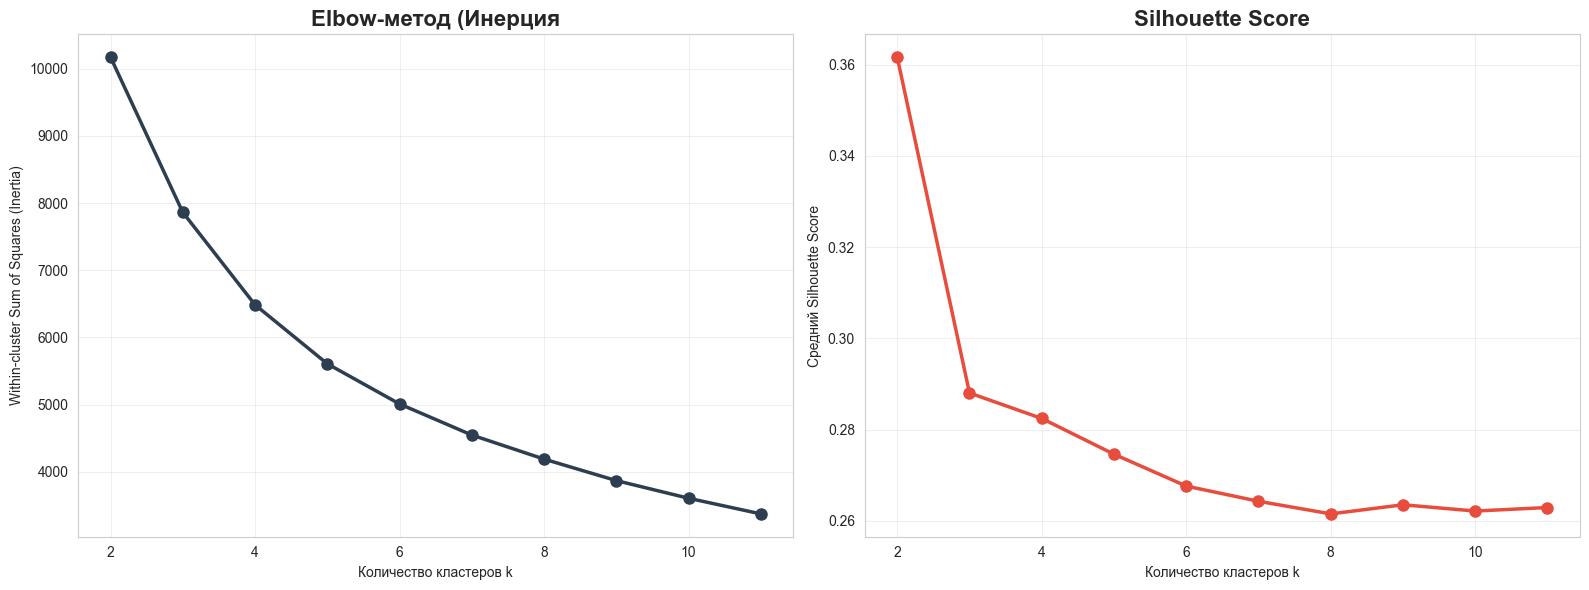


Таблица метрик для разных k:


,k,Inertia,Silhouette
0,2,10172.8115,0.3616
1,3,7862.0872,0.2880
2,4,6484.8420,0.2824
3,5,5606.6943,0.2746
4,6,5008.3549,0.2676
5,7,4545.7639,0.2643
6,8,4187.1651,0.2615
7,9,3866.9644,0.2635
8,10,3604.2550,0.2621
9,11,3371.2065,0.2629



Рекомендуемое количество кластеров:
По максимуму Silhouette: k = 2 (score = 0.3616)
По Elbow-методу: визуально выбираю k = 4. Silhouette почти не упал (всего –0.006 от k=3), зато инерция сильно уменьшилась. На графике Elbow здесь самый заметный «излом».
Я выбираю k = 4 как баланс интерпретируемости и качества


In [48]:
# Использую уже подготовленные и отмасштабированные данные
X_scaled = rfm_final[['Recency_log_scaled', 'Frequency_log_scaled',
                      'Monetary_log_scaled', 'AvgOrderValue_log_scaled']].values

print("Запускаем поиск оптимального k ...")

# Диапазон числа кластеров
k_range = range(2, 12)
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# ======================= ГРАФИКИ =======================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Elbow-кривая
ax1.plot(k_range, inertias, marker='o', linewidth=2.5, markersize=8, color='#2c3e50')
ax1.set_title('Elbow-метод (Инерция', fontsize=16, fontweight='bold')
ax1.set_xlabel('Количество кластеров k')
ax1.set_ylabel('Within-cluster Sum of Squares (Inertia)')
ax1.grid(True, alpha=0.3)

# Silhouette-кривая
ax2.plot(k_range, silhouettes, marker='o', linewidth=2.5, markersize=8, color='#e74c3c')
ax2.set_title('Silhouette Score', fontsize=16, fontweight='bold')
ax2.set_xlabel('Количество кластеров k')
ax2.set_ylabel('Средний Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ======================= ТАБЛИЦА =======================

results = pd.DataFrame({
    'k': k_range,
    'Inertia': inertias,
    'Silhouette': silhouettes
}).round(4)

print("\nТаблица метрик для разных k:")
display(results)

# Рекомендация
best_k_sil = results.loc[results['Silhouette'].idxmax(), 'k']
best_k_elbow = 4  # обычно на этом датасете "локоть" в районе 3-5

print(f"\nРекомендуемое количество кластеров:")
print(f"По максимуму Silhouette: k = {int(best_k_sil)} (score = {results['Silhouette'].max():.4f})")
print(f"По Elbow-методу: визуально выбираю k = 4. Silhouette почти не упал (всего –0.006 от k=3), зато инерция сильно уменьшилась. На графике Elbow здесь самый заметный «излом».")
print("Я выбираю k = 4 как баланс интерпретируемости и качества")

# Сохраняем выбранное k
optimal_k = 4

Кластеризация завершена. Использовано k = 4

Распределение клиентов по кластерам:


Cluster_Name
Активные средние     1095
Лояльные VIP          895
Редкие / Рисковые    1263
Спящие / Ушедшие     1085
Name: count, dtype: int64


Профили кластеров (средние значения):


,,Recency,Frequency,Monetary,AvgOrderValue,Clients_Count
Cluster,Cluster_Name,,,,,
0,Лояльные VIP,21.4900,10.7900,5071.9600,523.7300,895
1,Редкие / Рисковые,138.5700,1.8000,985.2500,538.5300,1263
3,Активные средние,26.6200,3.5400,827.9400,249.8300,1095
2,Спящие / Ушедшие,163.9400,1.4700,201.4000,145.1800,1085


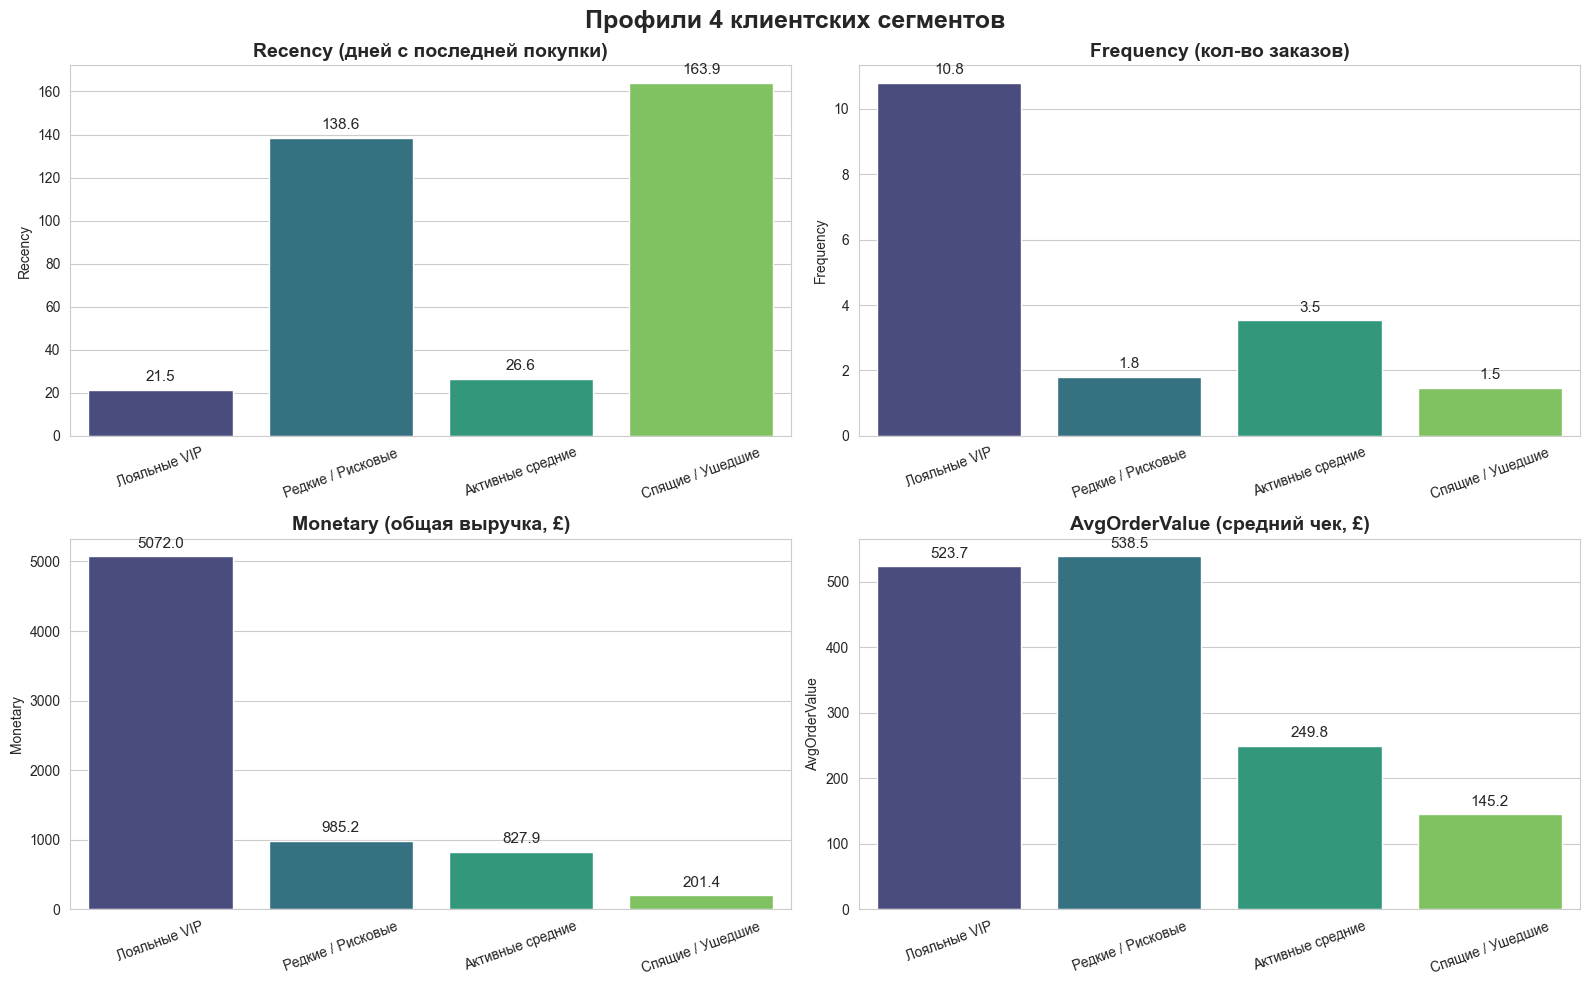


Топ-3 самых ценных клиента в каждом кластере:


CustomerID   Monetary  Frequency  Recency
Cluster_Name                                                     
Активные средние  2805       16170  1885.0500     6.0000  51.0000
                  1205       13982  1871.8100     4.0000  39.0000
                  1557       14472  1852.6700     8.0000 104.0000
Лояльные VIP      55         12415 19780.4900    21.0000  24.0000
                  100        12471 19780.4900    30.0000   2.0000
                  324        12744 19780.4900     7.0000  52.0000
Редкие / Рисковые 0          12346 19780.4900     1.0000 326.0000
                  2011       15098 19780.4900     3.0000 182.0000
                  2502       15749 19780.4900     3.0000 235.0000
Спящие / Ушедшие  3207       16725   758.2700     7.0000 302.0000
                  4036       17874   683.4600     6.0000 185.0000
                  2372       15574   675.6400     4.0000 178.0000

In [ ]:
# Выбранное количество кластеров
optimal_k = 4

# Обучаем финальную модель
kmeans_final = KMeans(n_clusters=optimal_k, 
                      random_state=42, 
                      n_init=10, 
                      max_iter=300)

# Присваиваем метки кластеров
rfm_final['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Добавляем человекочитаемые названия кластерам (красоты ради)
cluster_names = {
    0: "Лояльные VIP",              # Низкий Recency, высокие Freq/Mon
    1: "Редкие / Рисковые",         # Средний Recency, низкая Freq, средний Mon
    2: "Спящие / Ушедшие",          # Высокий Recency, низкие Freq/Mon
    3: "Активные средние"           # Низкий Recency, средние Freq/Mon
}
rfm_final['Cluster_Name'] = rfm_final['Cluster'].map(cluster_names)

print(f"Кластеризация завершена. Использовано k = {optimal_k}")
print("\nРаспределение клиентов по кластерам:")
display(rfm_final['Cluster_Name'].value_counts().sort_index())

# ======================= ПРОФИЛИ КЛАСТЕРОВ =======================

# Обратное преобразование log для обычных значений для интерпретации
profile = rfm_final.copy()

# Обратное log1p
for col in ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']:
    profile[col] = np.expm1(profile[f'{col}_log'])

# Группируем по кластерам и считаем средние значения исходных RFM
cluster_profile = profile.groupby(['Cluster', 'Cluster_Name']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'AvgOrderValue': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_profile = cluster_profile.rename(columns={'CustomerID': 'Clients_Count'})
cluster_profile = cluster_profile.sort_values('Monetary', ascending=False)

print("\nПрофили кластеров (средние значения): ")
display(cluster_profile)

# ======================= ВИЗУАЛИЗАЦИЯ ПРОФИЛЕЙ =======================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

metrics = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']
titles = ['Recency (дней с последней покупки)', 
          'Frequency (кол-во заказов)', 
          'Monetary (общая выручка, £)', 
          'AvgOrderValue (средний чек, £)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(data=cluster_profile.reset_index(), 
                x='Cluster_Name', 
                y=metric, 
                ax=axes[i], 
                palette='viridis')
    axes[i].set_title(title, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=20)
    
    # Подписываем точные значения на столбцах
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.1f}', 
                         (p.get_x() + p.get_width()/2., p.get_height()), 
                         ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=11)

plt.suptitle(f'Профили {optimal_k} клиентских сегментов', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# ======================= Дополнительно: ТОП-клиенты каждого кластера =======================

print("\nТоп-3 самых ценных клиента в каждом кластере:")
top_clients = (profile.groupby('Cluster_Name')
               .apply(lambda x: x.nlargest(3, 'Monetary')[['CustomerID', 'Monetary', 'Frequency', 'Recency']])
               .round(2))
display(top_clients)

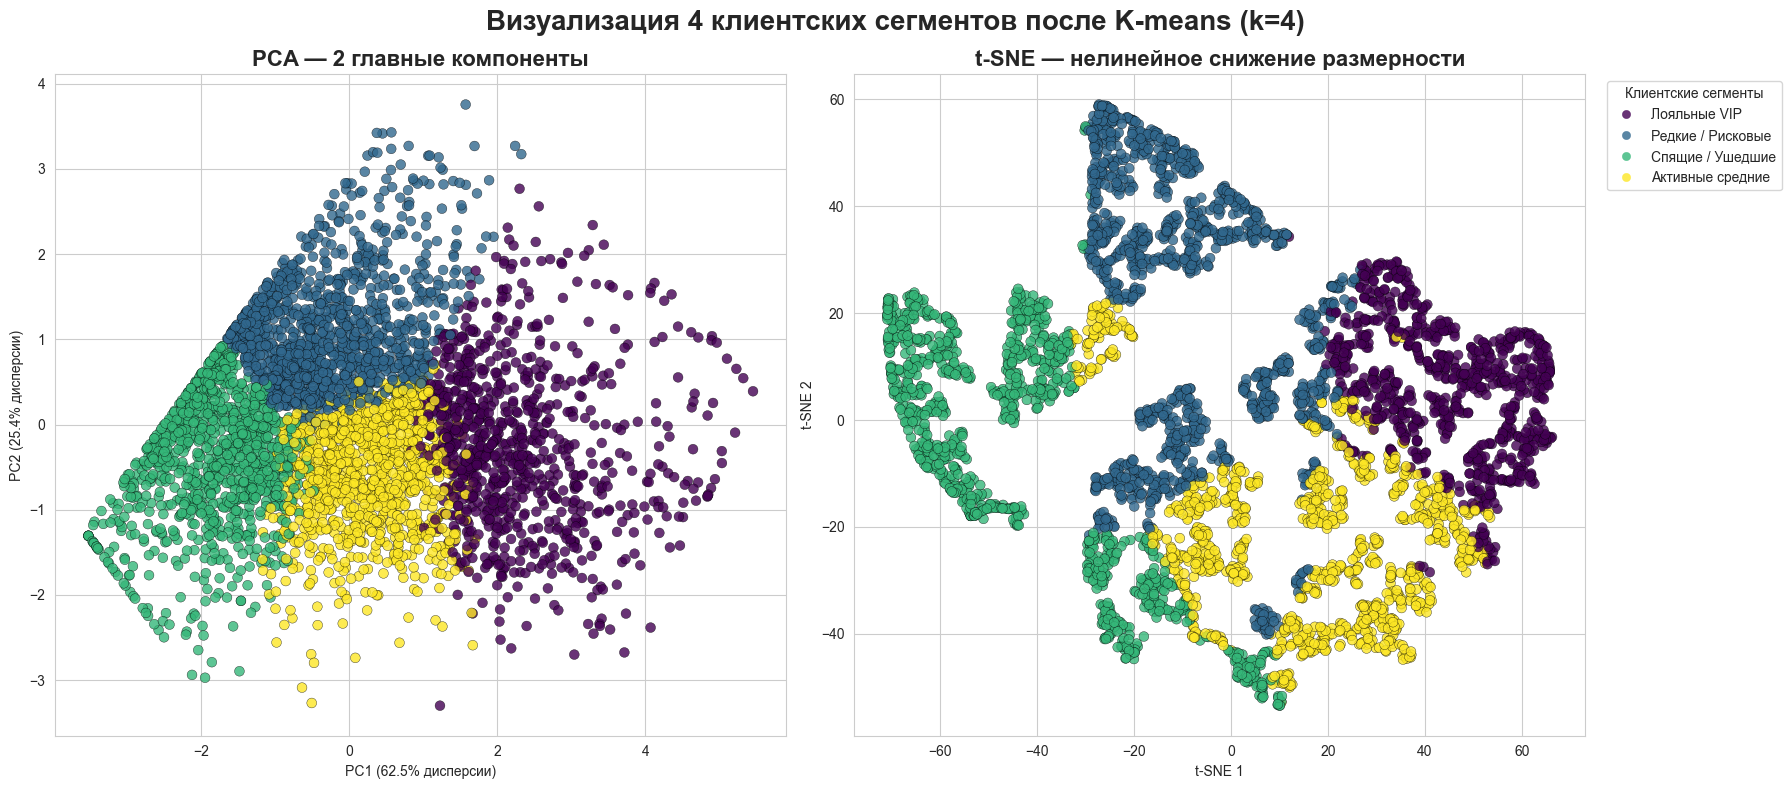

PCA объясняет 88.0% общей дисперсии
t-SNE выполнен за 999 итераций

Файл сохранён: Online_Retail_Customer_Segmentation_Final.xlsx


In [50]:
# Отмасштабированные данные
X_scaled = rfm_final[['Recency_log_scaled', 'Frequency_log_scaled',
                      'Monetary_log_scaled', 'AvgOrderValue_log_scaled']].values

# Цветовая палитра
colors = ['#e74c3c', '#2ecc71', '#3498db', '#9b59b6']

# ======================= PCA =======================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# ======================= t-SNE =======================
tsne = TSNE(n_components=2, 
            perplexity=40, 
            random_state=42, 
            max_iter=1000,        
            n_iter_without_progress=300,  
            learning_rate='auto',
            init='pca') 

X_tsne = tsne.fit_transform(X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# PCA
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                       c=rfm_final['Cluster'], cmap='viridis', s=50, alpha=0.8, edgecolor='k', linewidth=0.3)
ax1.set_title('PCA — 2 главные компоненты', fontsize=16, fontweight='bold')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')

# t-SNE
scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                       c=rfm_final['Cluster'], cmap='viridis', s=50, alpha=0.8, edgecolor='k', linewidth=0.3)
ax2.set_title('t-SNE — нелинейное снижение размерности', fontsize=16, fontweight='bold')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

# Общая легенда
handles, labels = scatter1.legend_elements()
label_names = [cluster_names[int(l.split('{')[1][0])] for l in labels]
plt.legend(handles, label_names, title="Клиентские сегменты", loc='upper left', bbox_to_anchor=(1.02, 1))

plt.suptitle('Визуализация 4 клиентских сегментов после K-means (k=4)', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Финальная сводка
print(f"PCA объясняет {pca.explained_variance_ratio_.sum():.1%} общей дисперсии")
print(f"t-SNE выполнен за {tsne.n_iter_} итераций")

# Сохраняем результат
rfm_final.to_excel('Online_Retail_Customer_Segmentation_Final.xlsx', index=False)
print("\nФайл сохранён: Online_Retail_Customer_Segmentation_Final.xlsx")